In [1]:
from river.metrics import RMSE
from data import get_synth_abrupt_datasets
from src.plot import Plots
from src.data import get_synth_datasets, get_real_datasets, get_synth_abrupt_datasets
from src.models import get_models
from utils import evaluate

In [2]:
# INSTANCES = 10_000
# real_datasets = get_real_datasets()
# models = get_models()
# logs = []
# for d_name, dataset_generator in real_datasets.items():
#     for model_name, model in models.items():
#         eval_model = {
#             model_name: model.clone()
#         }
#         eval_dataset_stream = {
#             d_name: dataset_generator().take(INSTANCES)
#         }
#         logs.append(evaluate(
#             eval_dataset_stream,
#             eval_model,
#             RMSE(),
#             print_every=INSTANCES/100
#         ))
# plot_gen = Plots()
# plot_gen.plot_all(logs)

In [3]:
# INSTANCES = 500_000
# synth_datasets = get_synth_datasets()
# models = get_models()
# logs = []
# for d_name, dataset_generator in synth_datasets.items():
#     for model_name, model in models.items():
#         eval_model = {
#             model_name: model.clone()
#         }
#         eval_dataset_stream = {
#             d_name: dataset_generator().take(INSTANCES)
#         }
#         logs.append(evaluate(
#             eval_dataset_stream,
#             eval_model,
#             RMSE(),
#             print_every=INSTANCES/100
#         ))
# plot_gen = Plots()
# for model_name,_ in models.items():
#     plot_gen.plot_band_for_model(logs, model_name)

Evaluating HTR (baseline) on friedman_drift_abrupt-GRA
Final RMSE: 2.379053: 2.379053
--------------------------------------------------
Evaluating HTR-QO (baseline) on friedman_drift_abrupt-GRA
Final RMSE: 2.627438: 2.627438
--------------------------------------------------
Evaluating HATR (baseline) on friedman_drift_abrupt-GRA
Final RMSE: 2.431206: 2.431206
--------------------------------------------------
Evaluating HTR-F-QO (α=0.9999, 1e-2) on friedman_drift_abrupt-GRA
Final RMSE: 2.445525: 2.445525
--------------------------------------------------
Evaluating HTR-F-QO (α=0.9999, 1e-3) on friedman_drift_abrupt-GRA
Final RMSE: 2.439503: 2.439503
--------------------------------------------------
Evaluating HTR-F-QO (α=0.999, 1e-2) on friedman_drift_abrupt-GRA
Final RMSE: 2.47017: 2.470170
--------------------------------------------------
Evaluating HTR (baseline) on friedman_drift_abrupt-2-LEA
Final RMSE: 2.215971: 2.215971
--------------------------------------------------
Eval

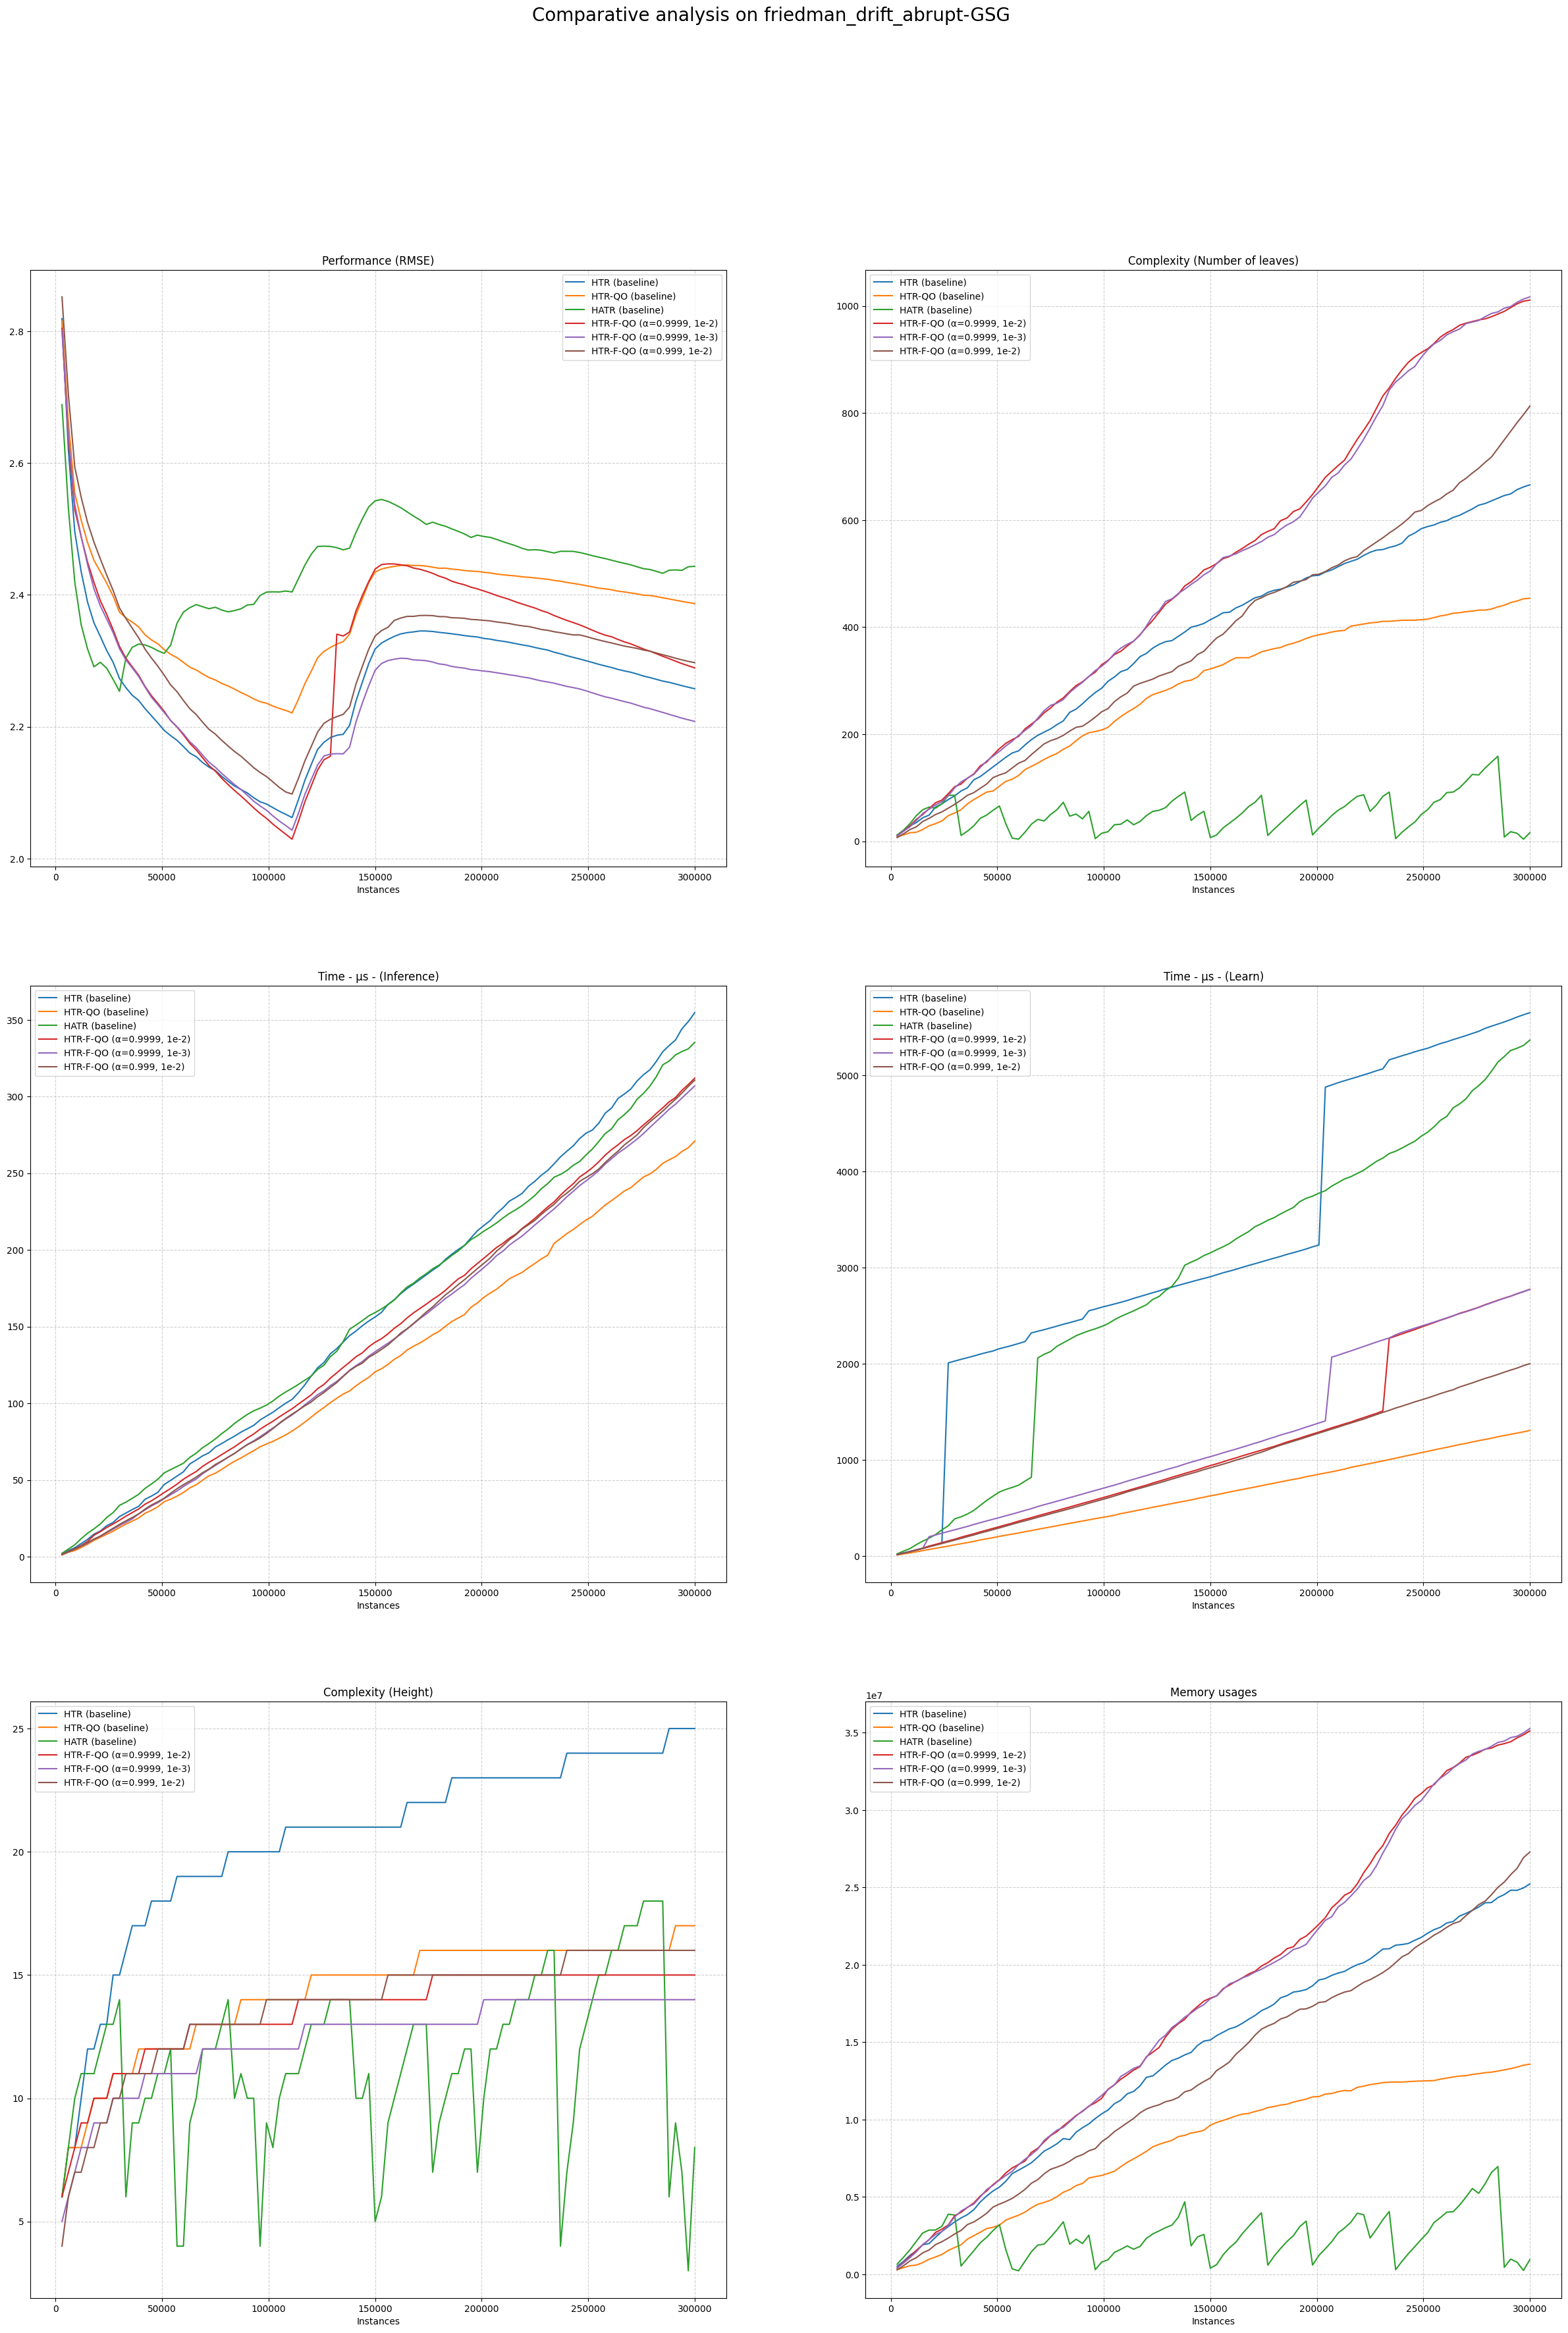

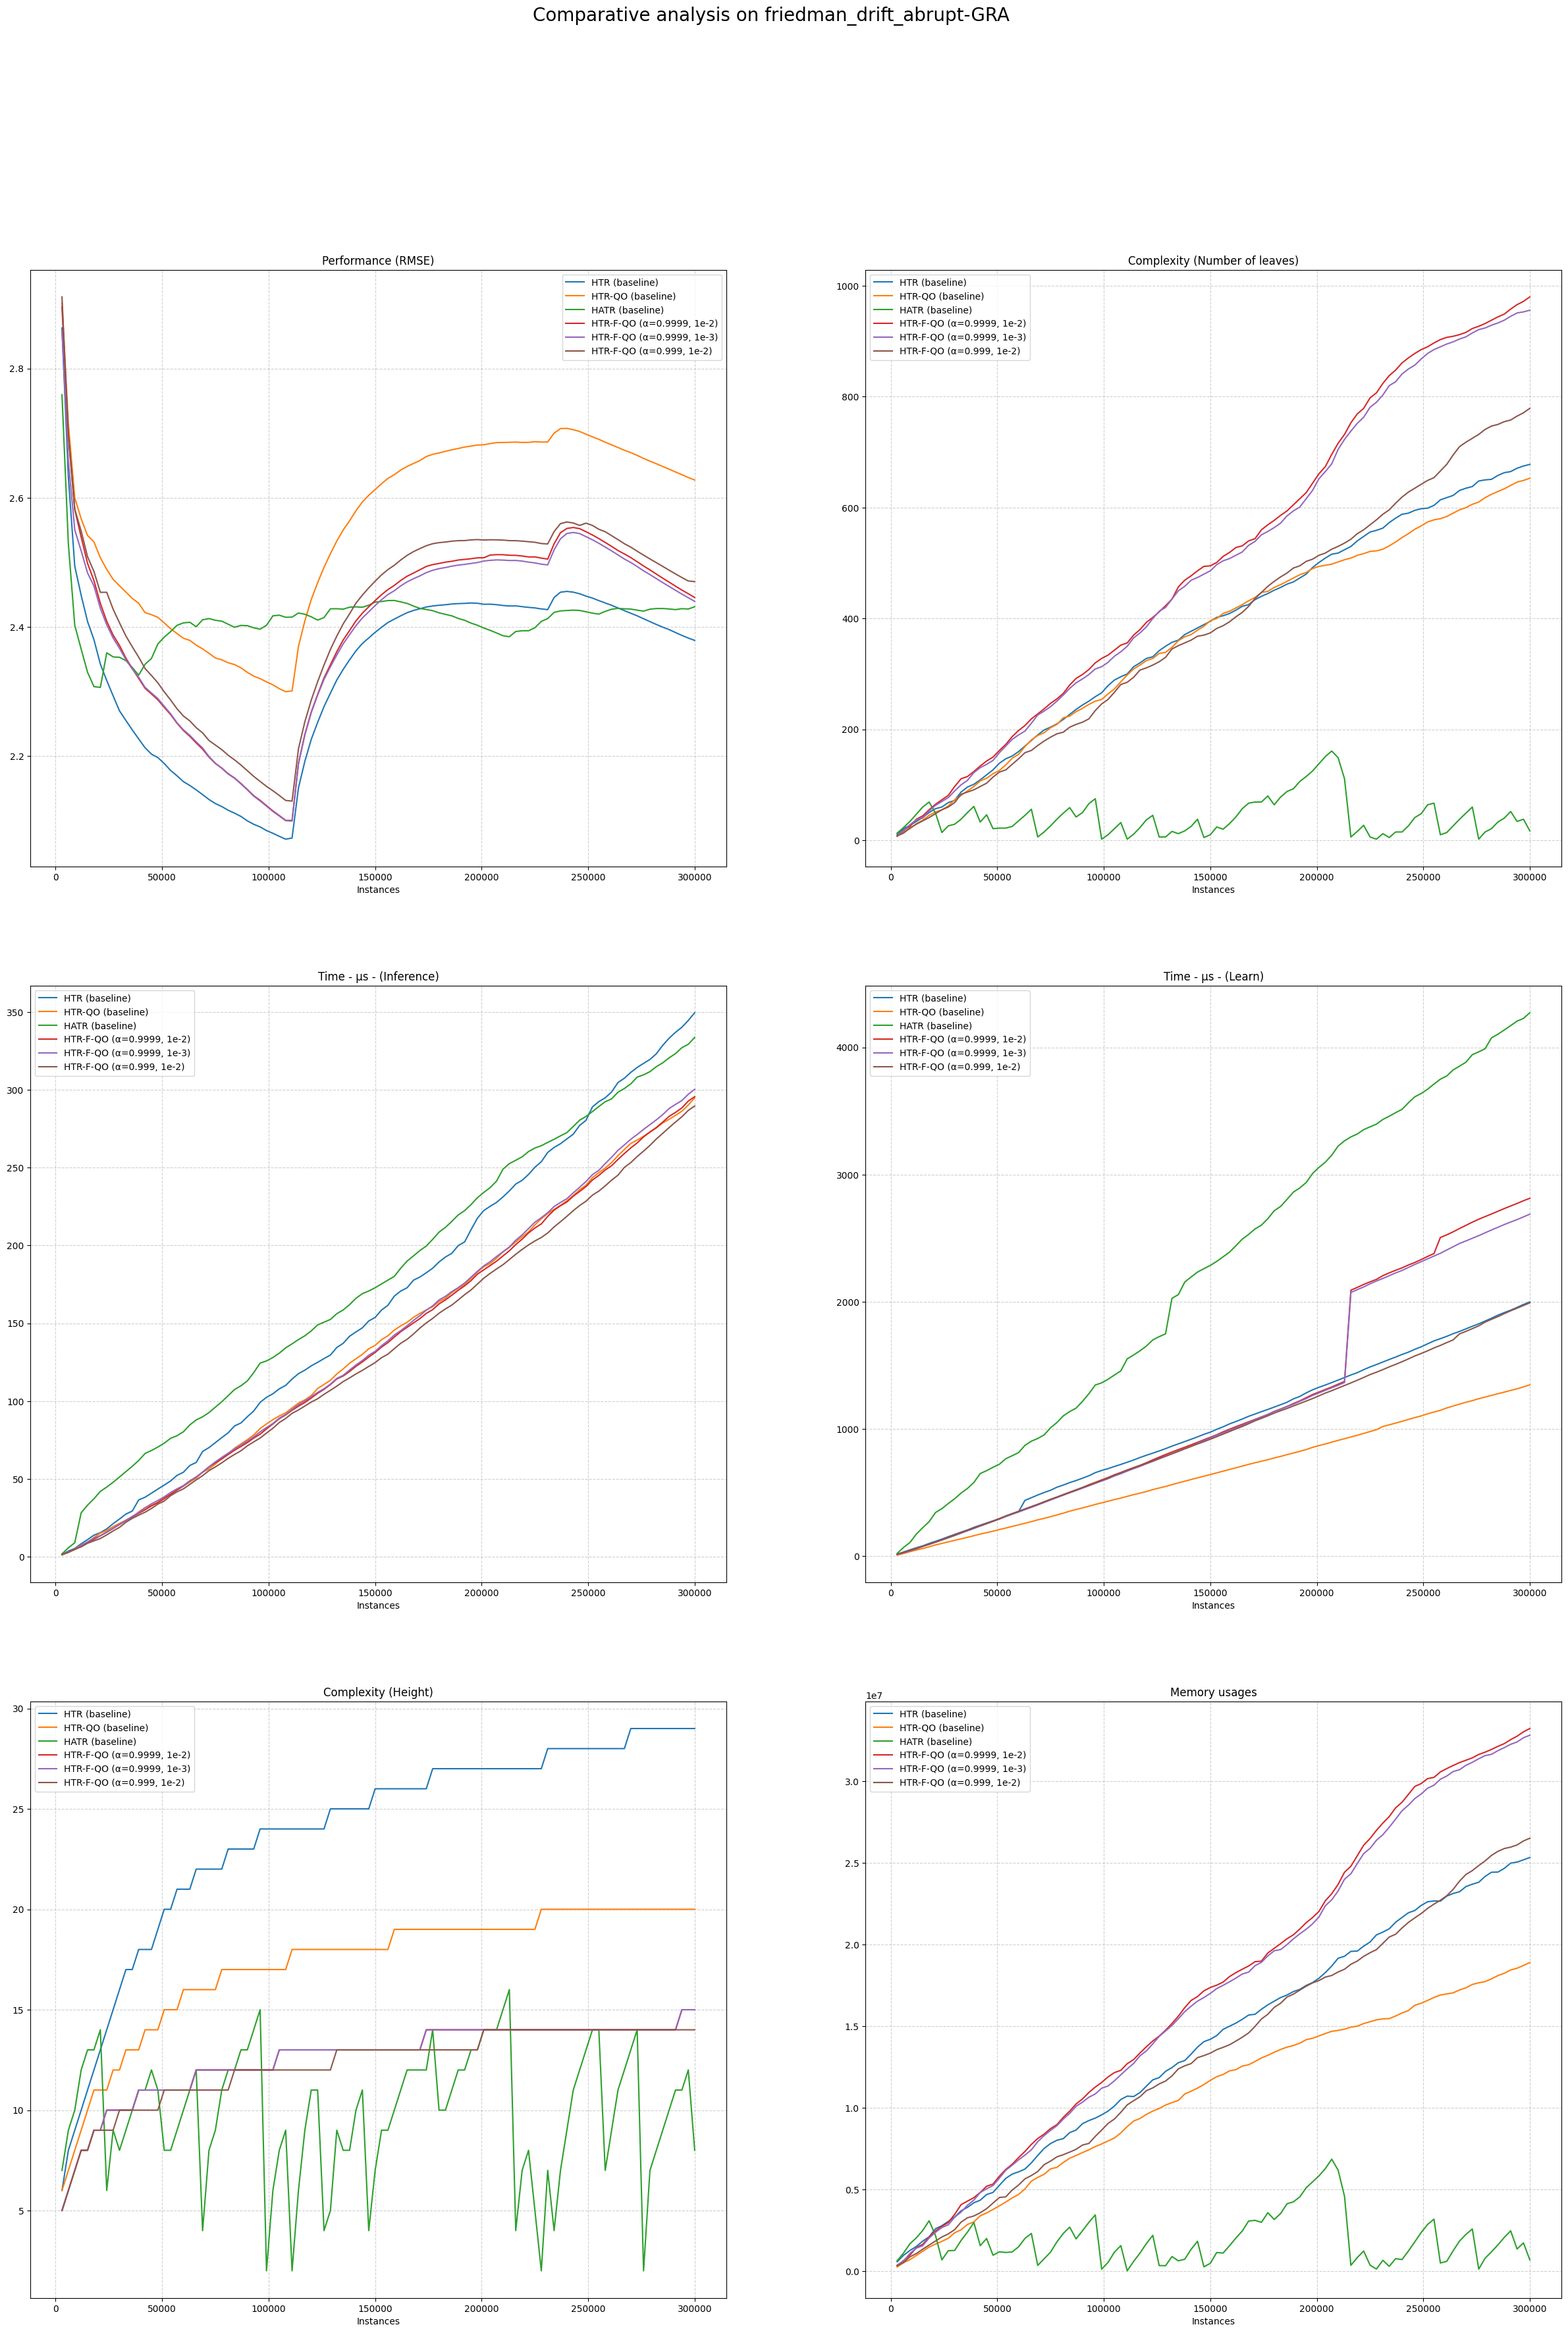

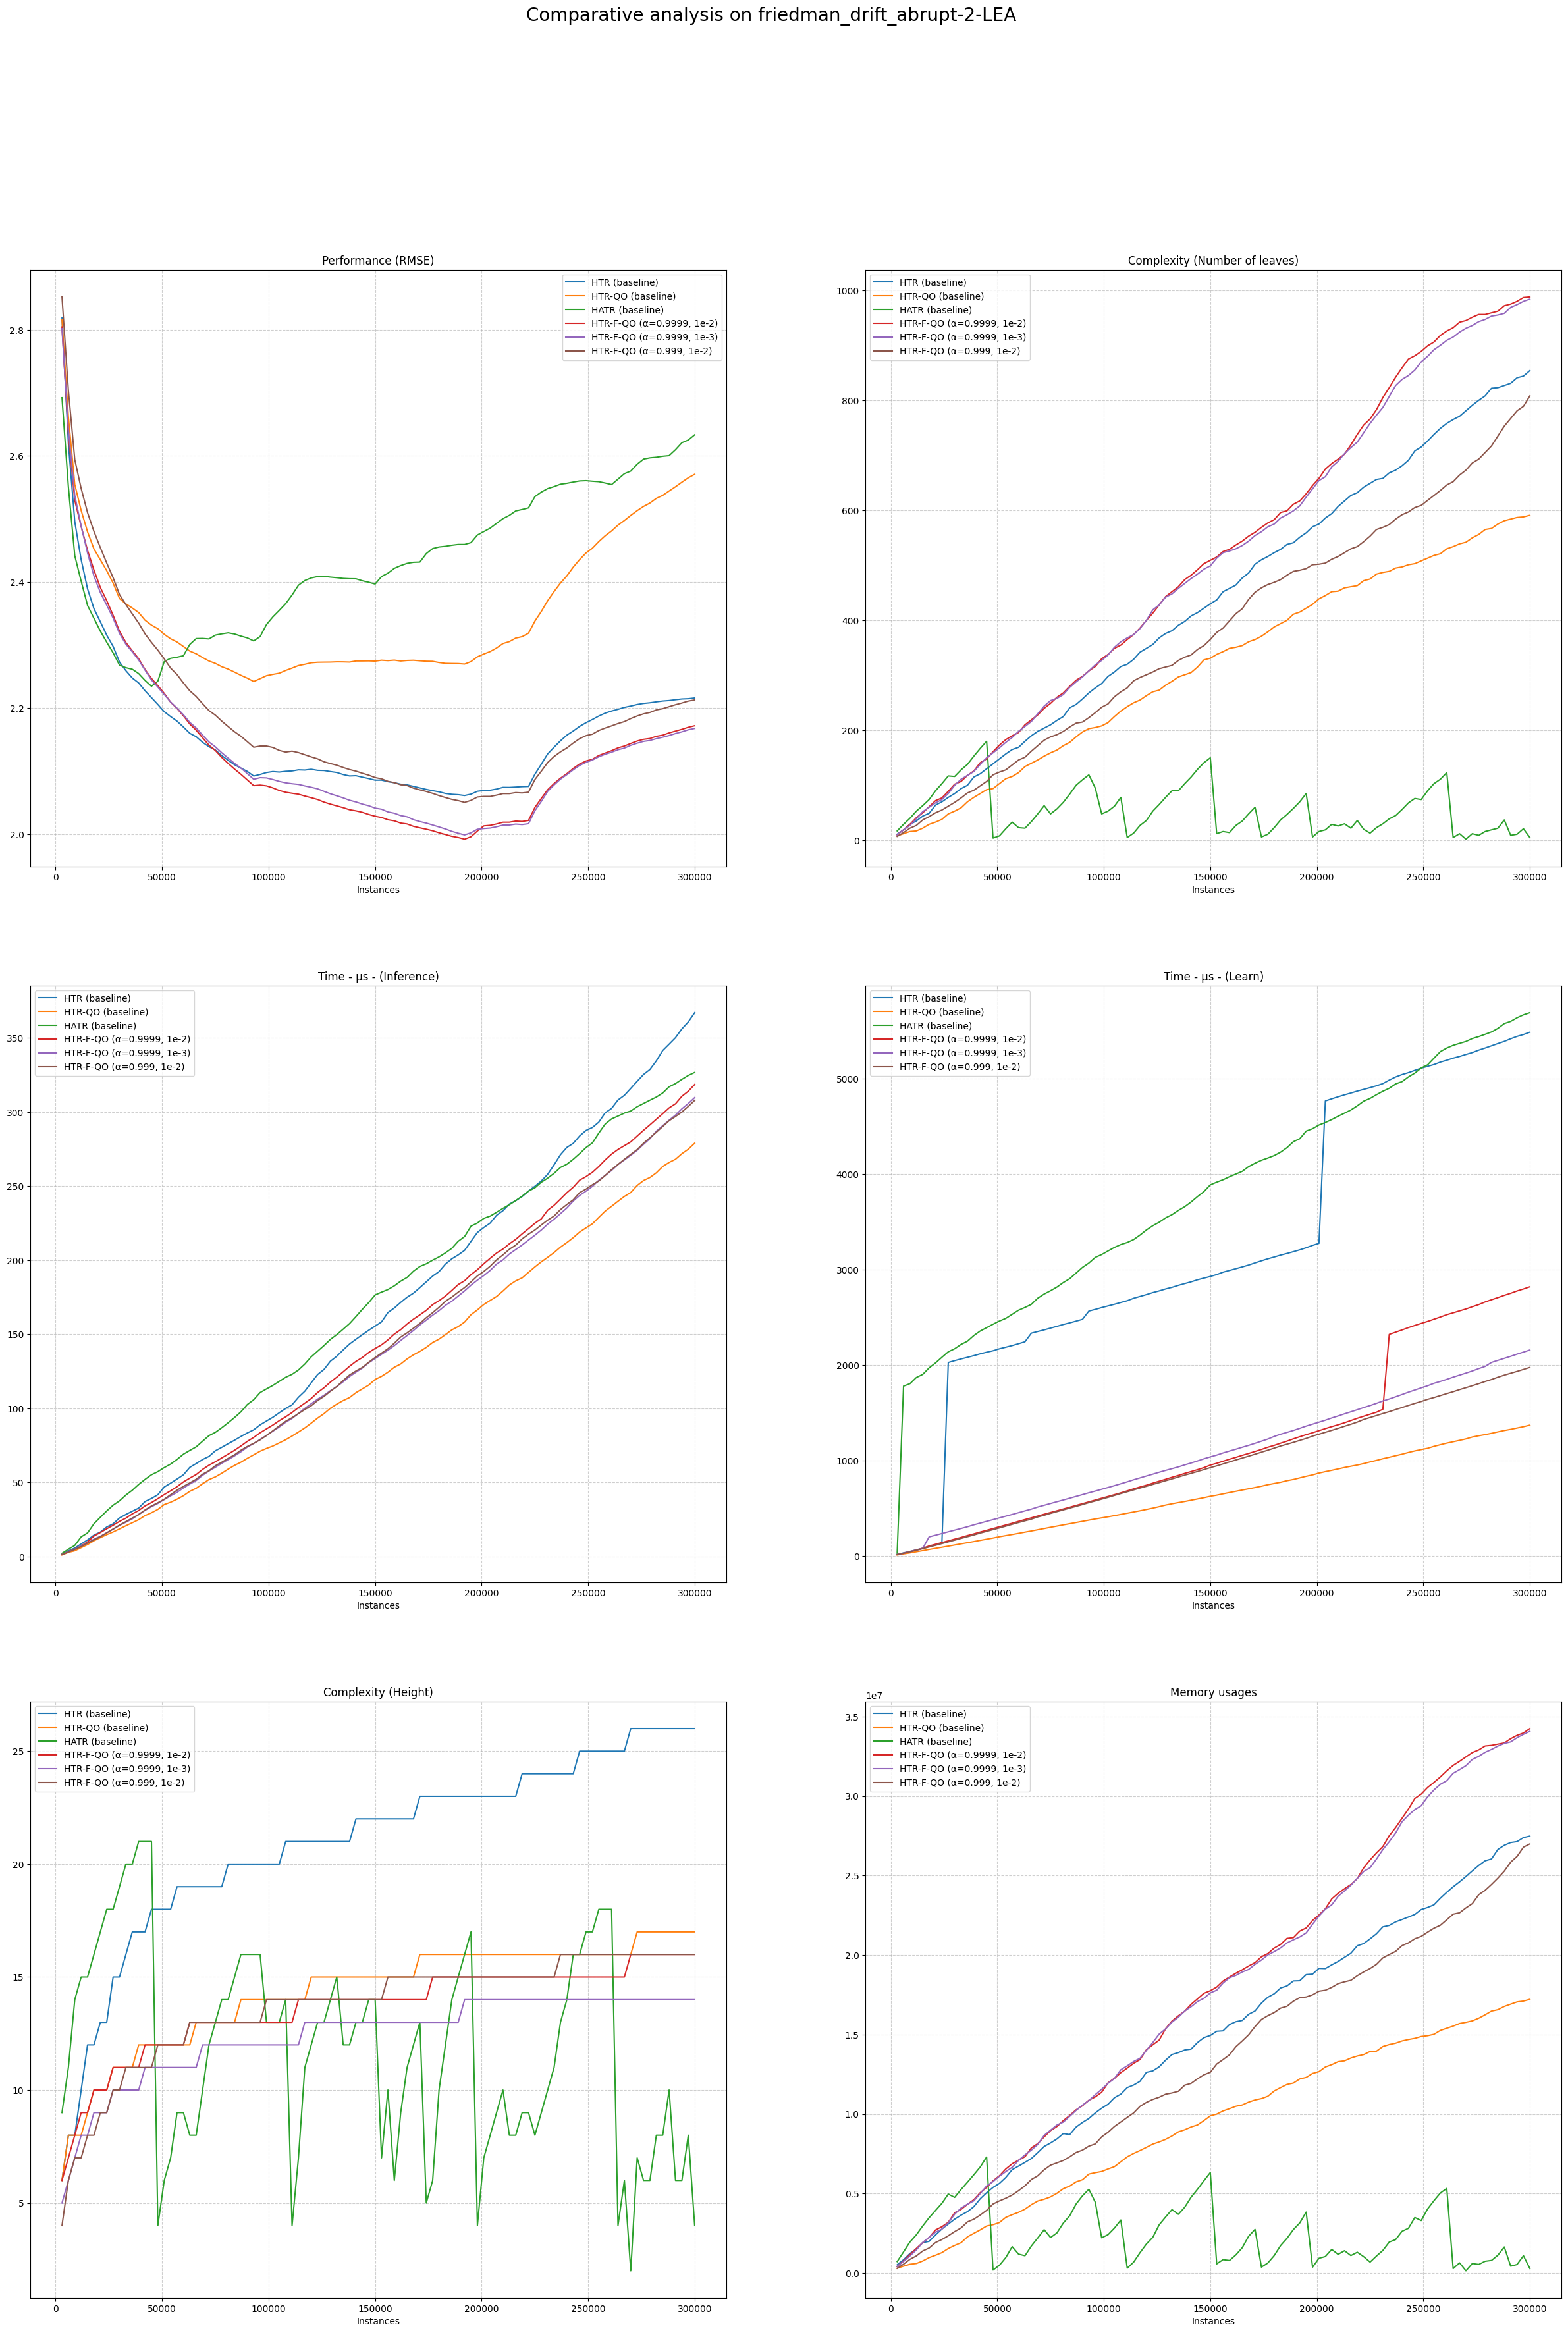

In [4]:
INSTANCES = 300_000
synth_datasets = get_synth_abrupt_datasets(INSTANCES)
models = get_models()
logs = []
for d_name, dataset_generator in synth_datasets.items():
    for model_name, model in models.items():
        eval_model = {
            model_name: model.clone()
        }
        eval_dataset_stream = {
            d_name: dataset_generator().take(INSTANCES)
        }
        logs.append(evaluate(
            eval_dataset_stream,
            eval_model,
            RMSE(),
            print_every=INSTANCES/100
        ))
plot_gen = Plots()
plot_gen.plot_all(logs)